In [112]:
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import numpy as np
import pandas as pd
from subprocess import call
from IPython.display import Image
import yfinance as yf


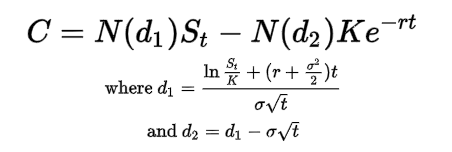

In [113]:
### This is the Black-Scholes Model used to price European style options. 
### We will be making a function for both calls and puts of european style using this formula
### to get the theoretical price of an option given certain inputs.
### We will also try and feed data directly from yahoo to see if we can get some options priced.

### Helpful links to understand the black-scholes more: https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model
###                                                     https://en.wikipedia.org/wiki/Put%E2%80%93call_parity

Image(filename='blackscholesformula.png')

In [114]:
# C = call option price
# N = CDF of the normal distribution
# S_t = spot price of an asset at time t
# K = strike price
# r = risk-free interest rate
# t = time to maturity
# σ = volatility of the asset

### you can multiply this formula by -1 and get the theoretical price of a Put, just make sure
### to carry the negative into the CDF of d_1 and d_2 (N(-d_1), N(-d_2))

In [115]:
## Below is a class that allows us to pass an instance and get a theoretical option premium.
## call_price and put_price are methods for calculating the price of a theoretical call/put after 
## you have created an instance for whatever contract is being analyzed.

class BlackScholes:
    
    def __init__(self, S, K, r, sigma, t):
        self.S = S
        self.K = K
        self.r = r
        self.sigma = sigma
        self.t = t
        self.d1 = (log(S/K)+(r+(sigma**2)/2)*t)/(sigma*sqrt(t))
        self.d2 = self.d1 - sigma*sqrt(t)
        
    def call_price(self):
        return self.S*norm.cdf(self.d1) - self.K*exp(-self.r*self.t)*norm.cdf(self.d2)
    
    def put_price(self):
        return self.K*exp(-self.r*self.t)*norm.cdf(-self.d2) - self.S*norm.cdf(-self.d1)


In [116]:
## IMPORTANT: time needs to be converted to years! 

d0 = date(2022, 1, 21)
jan_22_diff = d0 - date.today()
time = jan_22_diff.days/365


## I used historical volatility of 0.556 for tesla because this is the historical volatility for 180 days+.
## The risk free rate used was the 6-month treasury note.

tesla_jan_2022 = BlackScholes(668.91, 700, r=0.0005, sigma=.556, t=time)
theoretical_call = tesla_jan_2022.call_price()
theoretical_put = tesla_jan_2022.put_price()


## All values for "actual" price and price of Tesla shares were used as of close on 07/13/2021, and the midpoint
## between the bid-ask was used. 

actual_call = 94.68
actual_put = 124.70

print(f"""\nThe Black-Scholes model predicts that the Jan 2022 $700.00 strike Calls should be worth ${round(theoretical_call,2)} and the Puts should
be worth ${round(theoretical_put,2)}. \n\nThe actual values as of close on 07/13/2021 were ${actual_call} for the calls and ${actual_put} for the puts.\n""")



The Black-Scholes model predicts that the Jan 2022 $700.00 strike Calls should be worth $94.02 and the Puts should
be worth $124.93. 

The actual values as of close on 07/13/2021 were $94.68 for the calls and $124.7 for the puts.



In [117]:
## I will update this further to make data from yahoo feed into the valeus for the parameters in my 
## class. For now, this just gives an idea as to how we can use python to quickly calculate theoretical options
## prices!

In [118]:
## This method will retrieve the most recent value for daily closing prices of whatever ticker I want.
tickers = ["TSLA", "^IRX"]
def last_price(symbol):
    ticker = yf.Ticker(symbol)
    todays_data = ticker.history(period='1d')
    return todays_data['Close'][0]

ticker_values = []

for i in tickers:
    ticker_values.append(last_price(i))
    print(f"\n{i}'s closing price was",round(last_price(i),4))

print("\nThe ticker values save into ticker_values list:", ticker_values,"\n")


TSLA's closing price was 652.0958

^IRX's closing price was 0.043

The ticker values save into ticker_values list: [652.0958251953125, 0.0430000014603138] 



In [119]:
tsla = yf.Ticker('TSLA')
tsla_hist = tsla.history(period='max')


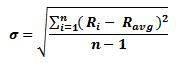

In [120]:
# Below is the calculation used for historical volatility for our chosen security:

Image(filename='historicalvol.png')

In [121]:
## We start by finding the daily returns for TSLA. We will multiply standard dev. of the last 252 days of returns
## by sqrt(252) to find the volatility. sqrt(252) is because we need to annualize the standard deviation.

## i.e. 𝜎^2 = SUM(𝜎_i^2) for i=1, n=252 for 252 trading days. There is also a covariance component for this, but we are
## assuming no covariance since there are no other variables.

## Therefore, we can continue by showing 𝜎^2 = 252 * 𝜎^2 (daily variance), take the square root and we get 
##     𝜎 (annual) = sqrt(252) * 𝜎 (daily)

# ------------------------------------------------------------------------------------------------------- #

## Below script creates a new column called "previous_close" which is the previous closing price of our stock.
## the next line is the calculation for daily return (will produce a NaN value for first obs.)

tsla_hist = tsla_hist.assign(previous_close = tsla_hist.Close.shift(1))
tsla_hist["Returns"] = (tsla_hist.Close - tsla_hist.previous_close)/tsla_hist.previous_close


## So now we can calculate sigma for the last 252 trading days:

sigma = sqrt(252) * tsla_hist["Returns"][-253:-1].std()
print(round(sigma, 4))

0.6942


In [122]:
## our sigma is pretty high, probably higher than what is realistic. However, this is likely due to the fact that the 
## year involved high amounts of volatility in the entire market, including incredible returns from TSLA shares.
## If this model were to go live, it would likely be best to take some average of multiple years from TSLA vol.

In [123]:
## Now to find a quick way to get t, duration (in years) until expiration.
## Basically just need to enter the year, month, and day of expiration. 

def time_duration(year, month, day):
    d = date(year, month, day)
    difference = d - date.today()
    time_dur = difference.days/365
    return time_dur

t = time_duration(2022, 1, 22)

In [124]:
## Now we have all of the variables covered except for strike price, which can be entered into a variable
## and then passed to the function, or we can just remember to specify K= strike_price in the function
## directly (i.e. K = 300 for a 300 strike contract)

S = ticker_values[0]
K = 700
r = ticker_values[1]

## sigma and t are already specified

tsla_contract_model = BlackScholes(S, K, r, sigma, t)
tsla_call = tsla_contract_model.call_price()
tsla_put = tsla_contract_model.put_price()

print(f"TSLA call theoretical price: {round(tsla_call,3)} \nTSLA put theoretical price: {round(tsla_put,3)}")

TSLA call theoretical price: 116.913 
TSLA put theoretical price: 149.242


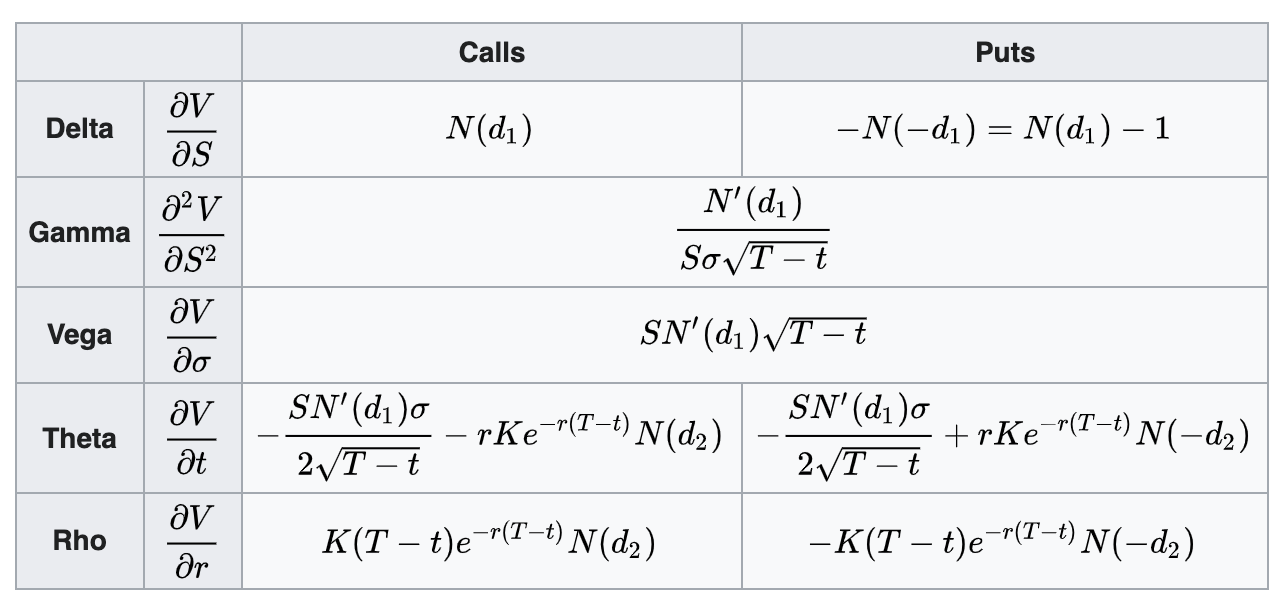

In [106]:
## Next we will write some code that calculates the greeks of our contracts. Below are the partial derivatives
## and the closed solutions for the greeks:

# source for the chart is wikipedia. 

Image(filename='greeks.png')

In [109]:
## (T-t) is equal to duration or time to expiration. 

## N' is the standard normal probability distribution function notation, in contrast to N which is the cumulative
## normal distribution function. 

## V(S,t) is seen as just V here, but it represents the function of the price of the contract of the underlying
## at time t. 

## Gamma and Vega are the same for both calls and puts, and there is a negative thrown into theta and rho for puts.

## I am going to first program these generally, then we will add them back into the class. So, right now
## each function will have parameters, but later they will just have "self" as the only parameter. 

In [129]:
## Note: we already defined d1 in the class, so we can call it directly as an instance variable. Our instance in this case
## is the tsla_contract_model. However, we do need to add a contract parameter to specify a call or put.

# Delta for calls and puts (use a string for contract parameter):

def delta(contract, S, K, r, sigma, t):
    
    if contract == "call":
        return norm.cdf(tsla_contract_model.d1)
    else:
        return norm.cdf(tsla_contract_model.d1) - 1

## Gamma (same for both):

def gamma(S, K, r, sigma, t):
    return (norm.pdf(tsla_contract_model.d1))/(S*sigma*sqrt(t))

## Vega (same for both):

def vega(S, K, r, sigma, t):
    return S*norm.pdf(tsla_contract_model.d1)*sqrt(t)

## Theta:

def theta(contract, S, K, r, sigma, t):
    
    if contract == "call":
        return -((S*norm.pdf(tsla_contract_model.d1)*sigma)/(2*t)) - r*K*exp(-r*t)*norm.cdf(tsla_contract_model.d2)
    else:
        return -((S*norm.pdf(tsla_contract_model.d1)*sigma)/(2*t)) + r*K*exp(-r*t)*norm.cdf(-tsla_contract_model.d2)
    
## Rho:

def rho(contract, S, K, r, sigma, t):
    
    if contract == "call":
        return K*t*exp(-r*t)*norm.cdf(tsla_contract_model.d2)
    else:
        return -K*t*exp(-r*t)*norm.cdf(-tsla_contract_model.d2)

In [144]:
### Tesla contract greeks:

tsla_call_delta = delta("call", S, K, r, sigma, t)
tsla_put_delta = delta("put", S, K, r, sigma, t)

tsla_gamma = gamma(S, K, r, sigma, t)
tsla_vega = vega(S, K, r, sigma, t)

tsla_call_theta = theta("call", S, K, r, sigma, t)
tsla_put_theta = theta("put", S, K, r, sigma, t)

tsla_call_rho = rho("call", S, K, r, sigma, t)
tsla_put_rho = rho("put", S, K, r, sigma, t)

call_dict = {
    "delta":tsla_call_delta,
    "gamma":tsla_gamma,
    "vega":tsla_vega,
    "theta":tsla_call_theta,
    "rho":tsla_call_rho
}

put_dict = {
    "delta":tsla_put_delta,
    "gamma":tsla_gamma,
    "vega":tsla_vega,
    "theta":tsla_put_theta,
    "rho":tsla_put_rho
}

In [159]:
print(f"\nTesla Jan 2022 Call greeks: \n")
for key in call_dict:
    print(f"{key.capitalize()} = {round(call_dict[key],4)}")
    
print(f"\nTesla Jan 2022 Put greeks: \n")
for key in put_dict:
    print(f"{key.capitalize()} = {round(put_dict[key],4)}")


Tesla Jan 2022 Call greeks: 

Delta = 0.5615
Gamma = 0.0012
Vega = 185.9493
Theta = -181.2102
Rho = 130.4147

Tesla Jan 2022 Put greeks: 

Delta = -0.4385
Gamma = 0.0012
Vega = 185.9493
Theta = -151.7799
Rho = -227.7364
